# Overview
This notebook is the 2nd notebook in my Pytorch Learning journey. I am following the [ZeroToMastery Pytorch course](https://www.learnpytorch.io/02_pytorch_classification/).

# Classification in Pytorch

In [56]:
import torch
# let's get to business
## first set up the device

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
torch.manual_seed(69)

cuda


In [57]:
# let's start by creating a non-linear classification dataset using sklearn
from sklearn.datasets import make_circles
import pandas as pd

n_samples = 4000
X, Y = make_circles(n_samples, noise=0.05, random_state=69, factor=0.75)

data = pd.DataFrame({"X1": X[:, 0], "X2": X[:, 1], "y": Y})
print(data.head())

         X1        X2  y
0 -0.884546 -0.358494  0
1  1.004633 -0.460166  0
2 -0.460955 -0.632895  1
3  0.577804  0.642630  1
4 -1.022173  0.152516  0


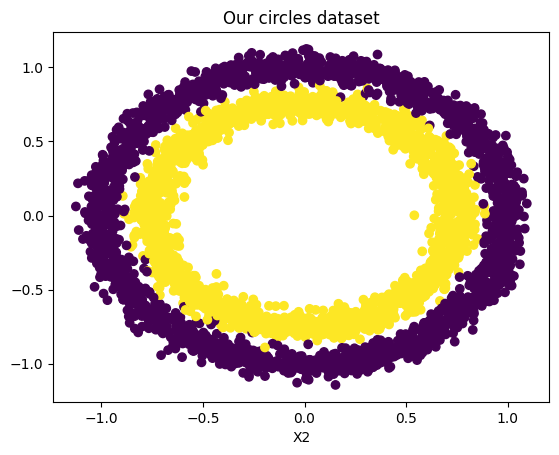

In [58]:
# plotting the data never hurt anybody!!!
import matplotlib.pylab as plt

plt.scatter(x=X[:, 0], y=X[:, 1], c=Y)
plt.xlabel('X1')
plt.xlabel('X2')
plt.title('Our circles dataset')
plt.show()


In [59]:
# let's get to work converting data to tensors and splitting the data and stuff...

X = torch.from_numpy(X).type(torch.float)# convert to a pytorch tensor and make sure the type is float
Y = torch.from_numpy(Y).type(torch.float)

# let's get ourselves a decent split
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=69, stratify=Y) # make sure the classes' distributions are the same in both train and test datasets

# set the device of the tensors
X_train = X_train.to(device)
X_test = X_test.to(device)
Y_train = Y_train.to(device)
Y_test = Y_test.to(device)

In [60]:
# let's create a function for calculating the accuracy of certain predictions given the target values
def accuracy_fn(y_true: torch.tensor, y_pred: torch.tensor, precision:int=3):
    
    # make sure to squeeze the tensors
    y_t = torch.squeeze(y_true)
    y_p = torch.squeeze(y_pred)
    assert y_t.size() == y_p.size()
    
    return round(torch.eq(y_true, y_pred).type(torch.float).mean().item(), precision) * 100 

In [64]:
# let's first create a linear model
from torch import nn

class LinearModel(nn.Module):
    def __init__(self, input_shape:int, num_classes:int, optimizer=None, metric=None, epochs:int=20, epochs_per_log:int=5):
        super().__init__()
        # let's save the values in a model's fields
        self.num_classes = num_classes
        self.input_shape = input_shape

        # let's create 2 layers to work with
        self.layer_1 = nn.Linear(in_features=input_shape, out_features=5) # make sure the inner dimensions match...
        self.layer_2 = nn.Linear(in_features=5, out_features= 1 if num_classes <= 2 else num_classes)
        self.output_layer = nn.Sigmoid() if num_classes <= 2 else nn.Softmax()

        # let's see how we can add some loss functions
        self.loss_function = nn.BCEWithLogitsLoss() if num_classes <= 2 else nn.CrossEntropyLoss()
        
        # the optimizer, the default is the stochastic Gradient descent this time
        self.optimizer = torch.optim.SGD(params=self.parameters(), lr=0.08) if optimizer is None else optimizer(params=self.parameters())

        # set the metric function (accuracy / precision / f1 score...)
        self.metric = accuracy_fn if metric is None else metric 

        # set the epochs' parameters        
        self.epochs = epochs # the number of epochs in the training loop
        self.epochs_per_log = epochs_per_log # how often should the error be displayed

        # create fields to save the progress
        self.train_losses = []
        self.train_metrics = []
        self.test_losses = []
        self.test_metrics = []

    def forward(self, x:torch.tensor) -> torch.tensor: 
        return self.output_layer(self.layer_2(self.layer_1(x))).squeeze()

    def test_model(self, X_test: torch.tensor, Y_test: torch.tensor, classes_only=True):
        # set the eval flag
        self.eval()
        # use the inference context manager
        with torch.inference_mode():
            y_probs = self(X_test)
            # set the classes
            y_pred = nn.argmax(y_probs, dim=0) if self.num_classes > 2 else torch.round(y_probs)
            # calculate the loss: for both multi and binary classification, the loss function is evaluated with the probabilities and not only the final classes
            y_test_loss = self.loss_function(y_pred, Y_test)
            y_test_metric = self.metric(Y_test, y_pred)
            # the returned values are tensors
            self.test_losses.append(y_test_loss.detach().item())
            self.test_metrics.append(y_test_metric)
            # decide what to return depending only the classes_only argument        
            if classes_only:
                return y_pred
            return y_pred, y_test_loss, y_test_metric


    # let's add training and testing loops
    def train_model(self, X_train: torch.tensor, Y_train: torch.tensor, X_test: torch.tensor=None, Y_test: torch.tensor=None):
        # first thing clear the saved previous losses and accuracies
        self.train_losses.clear()
        self.train_metrics.clear()
        self.test_losses.clear() 
        self.test_metrics.clear()

        # loop through the epochs
        for epo in range(self.epochs):
            # setting the model's model to train mode as we can switch to the test mode during certain epochs
            self.train()

            # calculate the probabilities
            y_probs = self(X_train)
            # determine the classes
            y_pred = nn.argmax(y_probs, dim=0) if self.num_classes > 2 else torch.round(y_probs)

            # calculating the loss function
            current_loss = self.loss_function(y_probs, Y_train)
            # calculate the classification's metric
            current_metric = self.metric(Y_train, y_pred)
            
            # save them in the corresponding list 
            self.train_losses.append(current_loss.detach().item())
            self.train_metrics.append(current_metric)

            # set zero gradient
            self.optimizer.zero_grad()
            current_loss.backward()
            self.optimizer.step()
            

            # if the test data is passed, then call the test loop
            if X_test is not None and Y_test is not None:
                # calculate the test loss and metrics
                self.test_model(X_test, Y_test)

                # display the necessary log
                if epo % self.epochs_per_log == 0:
                    print(f"The Train loss after {epo} epochs: {self.train_losses[-1]}. The train metric after {epo} epochs: {self.train_metrics[-1]}")
                    print(f"The Test loss after {epo} epochs: {self.test_losses[-1]}. The test metric after {epo} epochs: {self.test_metrics[-1]}")
                    print()


In [65]:
m1 = LinearModel(input_shape=2, num_classes=2)
m1.to(device)
m1.train_model(X_train, Y_train, X_test, Y_test)

The Train loss after 0 epochs: 0.7388103008270264. The train metric after 0 epochs: 50.0
The Test loss after 0 epochs: 0.8132617473602295. The test metric after 0 epochs: 50.0

The Train loss after 5 epochs: 0.737880527973175. The train metric after 5 epochs: 50.0
The Test loss after 5 epochs: 0.8132617473602295. The test metric after 5 epochs: 50.0

The Train loss after 10 epochs: 0.7369661927223206. The train metric after 10 epochs: 50.0
The Test loss after 10 epochs: 0.8132617473602295. The test metric after 10 epochs: 50.0

The Train loss after 15 epochs: 0.7360680103302002. The train metric after 15 epochs: 50.0
The Test loss after 15 epochs: 0.8132617473602295. The test metric after 15 epochs: 50.0



In [66]:
# let's download some helper functions for better re-use
import requests
import os

if os.path.isfile(os.path.join(os.getcwd(), 'helper_functions.py')):
    print("the file is already downloaded")
else:
    req = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open('helper_functions.py', 'wb') as f:
        f.write(req.content)

In [86]:
# let's improve the model a bit to see how things work

class ANN(LinearModel):
    # we need to modify the constructor
    def __init__(self, input_shape: int, num_classes: int, optimizer=None, metric=None, epochs: int = 20, epochs_per_log: int = 5):
        # use the parameters from the super class
        super().__init__(input_shape, num_classes, optimizer, metric, epochs, epochs_per_log)
        # let's add a relu layer
        self.relu = nn.ReLU()
    
    # modifying the forward function is a must as well
    def forward(self, x:torch.tensor) -> torch.tensor:    
        return self.output_layer(self.layer_2(self.relu(self.layer_1(x)))).squeeze()
        


In [87]:
m2 = ANN(input_shape=2, num_classes=2)
m2.to(device)
m2.train_model(X_train, Y_train, X_test, Y_test)

The Train loss after 0 epochs: 0.7223078012466431. The train metric after 0 epochs: 40.0
The Test loss after 0 epochs: 0.7750361561775208. The test metric after 0 epochs: 39.7

The Train loss after 5 epochs: 0.7218144536018372. The train metric after 5 epochs: 38.0
The Test loss after 5 epochs: 0.7756896615028381. The test metric after 5 epochs: 38.2

The Train loss after 10 epochs: 0.7213302254676819. The train metric after 10 epochs: 36.7
The Test loss after 10 epochs: 0.7802649140357971. The test metric after 10 epochs: 36.3

The Train loss after 15 epochs: 0.7208575010299683. The train metric after 15 epochs: 37.8
The Test loss after 15 epochs: 0.7719017863273621. The test metric after 15 epochs: 37.3



In [63]:
# let's take a random sample for our data and see the model in action
from random import sample
import random 
random.seed(69)
ran_indices = sample(list(range(X.shape[0])), 50)

random_X = X[ran_indices, :].to(device)
random_Y = Y[ran_indices].to(device)

m1(random_X[0, :10])

tensor(0.4257, device='cuda:0', grad_fn=<SqueezeBackward0>)